In [13]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import cv2
import os

print("NumPy:", np.__version__)
print("Matplotlib:", plt.matplotlib.__version__)
print("OpenCV:", cv2.__version__)

NumPy: 1.26.4
Matplotlib: 3.9.2
OpenCV: 4.9.0


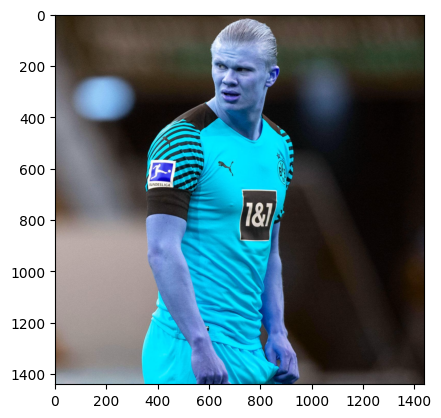

In [19]:
img = cv2.imread("erling-haaland-bvb.jpg")
plt.imshow(img)
plt.show()

In [50]:
# Initialize face and eye cascade classifiers
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

In [53]:
def get_cropped_image_if_2_eyes(image_path):

    img = cv2.imread(image_path)
    if img is None:
        print(f'{img} was not read successfully')
        
    # Convert to grayscale for detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    result_img = img.copy()
    face_count = 0
    total_eyes = 0
    print(f"Found {len(faces)} face(s)")
    
    # Draw rectangles around faces and detect eyes
    for (x, y, w, h) in faces:
        face_count += 1
        
        # Draw green rectangle around face
        cv2.rectangle(result_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        # Define regions of interest for eye detection
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = result_img[y:y+h, x:x+w]
        
        # Detect eyes in the face region
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color
            
    return None

In [85]:
path_to_data = './dataset'
path_to_cr_data = './dataset/cropped'

In [86]:
import os 
img_dirs = []

# Adding celebrity names from folders into img_dirs
for entry in os.scandir(path_to_data):
    if entry.is_dir() and entry.name != 'cropped':
        img_dirs.append(entry.path)

print(f'Folders found: {img_dirs}')

Folders found: ['./dataset\\haaland', './dataset\\kdb', './dataset\\messi']


In [87]:
import shutil

# Remove existing ./dataset/cropped folder and create new one 
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [90]:
# main function 
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs: 
    celebrity_name = os.path.basename(img_dir)
    print(f'Processing: {celebrity_name}...')

    # Created folder for celebrity inside cropped and dir stored in cropped_images_dir
    cropped_folder = os.path.join(path_to_cr_data, celebrity_name)
    if not os.path.isdir(cropped_folder):
        os.makedirs(cropped_folder)
        cropped_image_dirs.append(cropped_folder)
        print(f'Created cropped folder for: {cropped_folder}')

    # Celebrity name stored as key with Array[] as value 
    celebrity_file_names_dict[celebrity_name] = []
    count = 1 

    for entry in os.scandir(img_dir):
        if entry.is_file() and entry.name.lower().endswith(('.png', '.jpg', '.jpeg')):
            print(f"    Processing file {entry.name}....")
            
            # Apply function to check if face & eyes exists 
            roi_color = get_cropped_image_if_2_eyes(entry.path)

        if roi_color is not None and roi_color.size > 0:
            # Create cropped file path and name 
            cropped_file_name  = f"{celebrity_name}{count}.png"
            cropped_file_path = os.path.join(cropped_folder, cropped_file_name)

            # Save file to the cropped folder
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            print(f"    Saved file {cropped_file_name}")
            count += 1 
            
        else:
            print(f"    Did not save {entry.name}, No face with 2 eyes detected")
        
print("==========")
print("Summary")
print("==========")
for celebrity, images in celebrity_file_names_dict.items():
    print(f"{celebrity}: {len(images)} cropped images")
    
print(f"\nCropped images saved in: {path_to_cr_data}")

Processing: haaland...
    Processing file 107058322-gettyimages-1319456980-ma1_6459_2021052213917637.jpg....
Found 0 face(s)
    Did not save 107058322-gettyimages-1319456980-ma1_6459_2021052213917637.jpg, No face with 2 eyes detected
    Processing file 1229440108.jpg....
Found 1 face(s)
    Did not save 1229440108.jpg, No face with 2 eyes detected
    Processing file 1229481145.jpg_quality=90&strip=all&crop=0_2C0.0058336250145814_2C100_2C99.jpg....
Found 1 face(s)
    Saved file haaland1.png
    Processing file 1231354362.jpg_quality=90&strip=all&crop=0,9.5120073891626,100,44.jpg....
Found 0 face(s)
    Did not save 1231354362.jpg_quality=90&strip=all&crop=0,9.5120073891626,100,44.jpg, No face with 2 eyes detected
    Processing file 1233714478.jpg_quality=90&strip=all&crop=0.0081806282722496_2C0_2C99.jpg....
Found 1 face(s)
    Saved file haaland2.png
    Processing file 129471-untitled-design-1.jpg....
Found 1 face(s)
    Saved file haaland3.png
    Processing file 1297311861.jpg_

In [91]:
import pywt
import os

def w2d(img, mode='haar', level=1):
    """
    Apply 2D wavelet transform to extract features
    """
    imArray = img
    
    # Convert to grayscale if image is colored
    if len(imArray.shape) == 3:
        imArray = cv2.cvtColor(imArray, cv2.COLOR_BGR2GRAY)  # Fixed: cv2.cvtColor9 -> cv2.cvtColor
    
    # Convert to float
    imArray = np.float32(imArray)
    imArray /= 255.0
    
    # Compute wavelet decomposition
    coeffs = pywt.wavedec2(imArray, mode, level=level)  # Fixed: pwty -> pywt
    
    # Process Coefficients - zero out approximation coefficients
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0
    
    # Reconstruction
    imArray_H = pywt.waverec2(coeffs_H, mode)
    imArray_H *= 255
    imArray_H = np.uint8(imArray_H)
    
    return imArray_H

In [92]:
# Create class dictionary
class_dict = {}
count = 1
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count += 1

print("Class mapping:", class_dict)

Class mapping: {'haaland': 1, 'kdb': 2, 'messi': 3}


In [93]:
# Prepare features and labels
X, y = [], []
skipped_files = []

for celebrity_name, training_files in celebrity_file_names_dict.items():
    print(f"\nProcessing {celebrity_name}:")
    valid_files_count = 0
    
    for training_image in training_files:
        # Check if file exists
        if not os.path.exists(training_image):
            skipped_files.append(training_image)
            print(f"  Skipped (file not found): {training_image}")
            continue
            
        img = cv2.imread(training_image)

        # If the image could not be read 
        if img is None: 
            skipped_files.append(training_image)
            print(f"  Skipped (could not read): {training_image}")
            continue
        
        try:
            # Resize original image
            scaled_raw_img = cv2.resize(img, (32, 32))
            
            # Apply wavelet transform
            img_har = w2d(img, 'db1', 5)
            scaled_img_har = cv2.resize(img_har, (32, 32))
            
            # Combine features
            # Raw image features (flattened)
            raw_features = scaled_raw_img.reshape(32*32*3, 1)
            
            # Wavelet features (flattened)
            har_features = scaled_img_har.reshape(32*32, 1)
            
            # Combine both feature sets
            combined_img = np.vstack([raw_features, har_features])
            
            X.append(combined_img.flatten())  # Flatten for easier handling
            y.append(class_dict[celebrity_name])
            valid_files_count += 1
            
        except Exception as e:
            skipped_files.append(training_image)
            print(f"  Error processing {training_image}: {e}")
            continue
    
    print(f"  Successfully processed: {valid_files_count} images")

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

print(f"\n=== FEATURE ENGINEERING SUMMARY ===")
print(f"Total samples: {len(X)}")
print(f"Feature vector size: {X.shape[1] if len(X) > 0 else 0}")
print(f"Classes: {len(class_dict)}")
print(f"Skipped files: {len(skipped_files)}")


Processing haaland:
  Successfully processed: 42 images

Processing kdb:
  Successfully processed: 45 images

Processing messi:
  Successfully processed: 52 images

=== FEATURE ENGINEERING SUMMARY ===
Total samples: 139
Feature vector size: 4096
Classes: 3
Skipped files: 0


In [96]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def optimize_models(X, y, test_size=0.2, random_state=42):
    """
    Comprehensive model optimization with multiple algorithms and hyperparameter tuning
    """
    
    # Split the data with stratification to maintain class balance
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    print(f"Training samples: {len(X_train)}")
    print(f"Testing samples: {len(X_test)}")
    print(f"Feature dimensions: {X.shape[1]}")
    
    # Define model configurations with corrected parameter names
    model_configs = {
        'SVM_RBF': {
            'pipeline': Pipeline([
                ('scaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),  # Keep 95% variance
                ('svc', SVC(probability=True, random_state=random_state))
            ]),
            'params': {
                'pca__n_components': [0.90, 0.95, 0.99, None],
                'svc__C': [0.1, 1, 10, 100, 1000],
                'svc__kernel': ['rbf'],
                'svc__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
            }
        },
        
        'SVM_Linear': {
            'pipeline': Pipeline([
                ('scaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('svc', SVC(probability=True, random_state=random_state))
            ]),
            'params': {
                'pca__n_components': [0.90, 0.95, 0.99, None],
                'svc__C': [0.1, 1, 10, 100],
                'svc__kernel': ['linear']
            }
        },
        
        'Logistic_Regression': {
            'pipeline': Pipeline([
                ('scaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('lr', LogisticRegression(random_state=random_state, max_iter=1000))
            ]),
            'params': {
                'pca__n_components': [0.90, 0.95, 0.99, None],
                'lr__C': [0.01, 0.1, 1, 10, 100],
                'lr__solver': ['liblinear', 'lbfgs'],
                'lr__penalty': ['l2']
            }
        }
    }
    
    # Store results
    results = {}
    best_models = {}
    
    # Cross-validation setup
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    
    print("\n" + "="*60)
    print("HYPERPARAMETER TUNING AND MODEL EVALUATION")
    print("="*60)
    
    for model_name, config in model_configs.items():
        print(f"\n🔍 Optimizing {model_name}...")
        
        # Grid search with cross-validation
        grid_search = GridSearchCV(
            config['pipeline'], 
            config['params'], 
            cv=cv,
            scoring='accuracy',
            n_jobs=-1,
            verbose=1
        )
        
        # Fit the grid search
        grid_search.fit(X_train, y_train)
        
        # Get the best model
        best_model = grid_search.best_estimator_
        best_models[model_name] = best_model
        
        # Predictions
        y_pred = best_model.predict(X_test)
        y_pred_proba = best_model.predict_proba(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Cross-validation score
        cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='accuracy')
        
        # Store results
        results[model_name] = {
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            'test_accuracy': accuracy,
            'test_f1': f1,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
        
        print(f"✅ {model_name} Results:")
        print(f"   Best CV Score: {grid_search.best_score_:.4f}")
        print(f"   Test Accuracy: {accuracy:.4f}")
        print(f"   Test F1-Score: {f1:.4f}")
        print(f"   CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
        print(f"   Best Parameters: {grid_search.best_params_}")
    
    # Find the best overall model
    best_model_name = max(results.keys(), key=lambda k: results[k]['test_accuracy'])
    best_overall_model = best_models[best_model_name]
    
    print(f"\n🏆 BEST MODEL: {best_model_name}")
    print(f"   Test Accuracy: {results[best_model_name]['test_accuracy']:.4f}")
    print(f"   Test F1-Score: {results[best_model_name]['test_f1']:.4f}")
    
    return results, best_models, X_test, y_test, best_model_name

In [99]:
results, best_models, X_test, y_test, best_model_name = optimize_models(X, y)

Training samples: 111
Testing samples: 28
Feature dimensions: 4096

HYPERPARAMETER TUNING AND MODEL EVALUATION

🔍 Optimizing SVM_RBF...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
✅ SVM_RBF Results:
   Best CV Score: 0.8289
   Test Accuracy: 0.8571
   Test F1-Score: 0.8577
   CV Score: 0.8289 (+/- 0.0675)
   Best Parameters: {'pca__n_components': 0.95, 'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}

🔍 Optimizing SVM_Linear...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
✅ SVM_Linear Results:
   Best CV Score: 0.9016
   Test Accuracy: 0.8929
   Test F1-Score: 0.8946
   CV Score: 0.9016 (+/- 0.1298)
   Best Parameters: {'pca__n_components': 0.95, 'svc__C': 0.1, 'svc__kernel': 'linear'}

🔍 Optimizing Logistic_Regression...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
✅ Logistic_Regression Results:
   Best CV Score: 0.8474
   Test Accuracy: 0.8929
   Test F1-Score: 0.8921
   CV Score: 0.8474 (+/- 0.1188)
   Best Parameters: {'

In [100]:
def detailed_evaluation(results, best_models, X_test, y_test, best_model_name, class_names):
    """
    Provide detailed evaluation of the best model
    """
    best_model = best_models[best_model_name]
    y_pred = results[best_model_name]['y_pred']
    
    print(f"\n📊 DETAILED EVALUATION - {best_model_name}")
    print("="*50)
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(12, 5))
    
    # Plot confusion matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {best_model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Plot model comparison
    plt.subplot(1, 2, 2)
    model_names = list(results.keys())
    test_scores = [results[name]['test_accuracy'] for name in model_names]
    cv_scores = [results[name]['cv_mean'] for name in model_names]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    plt.bar(x - width/2, test_scores, width, label='Test Accuracy', alpha=0.8)
    plt.bar(x + width/2, cv_scores, width, label='CV Accuracy', alpha=0.8)
    
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title('Model Comparison')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    plt.tight_layout()
    
    plt.show()
    
    return best_model


📊 DETAILED EVALUATION - SVM_Linear

Classification Report:
              precision    recall  f1-score   support

     haaland       1.00      0.75      0.86         8
         kdb       0.75      1.00      0.86         9
       messi       1.00      0.91      0.95        11

    accuracy                           0.89        28
   macro avg       0.92      0.89      0.89        28
weighted avg       0.92      0.89      0.89        28



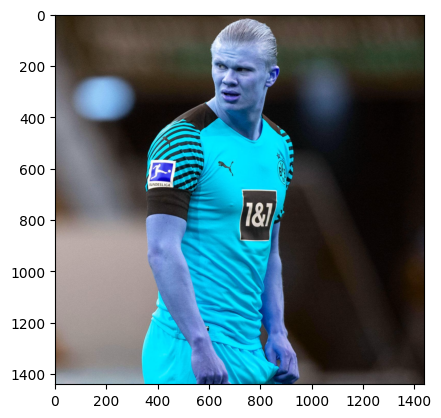

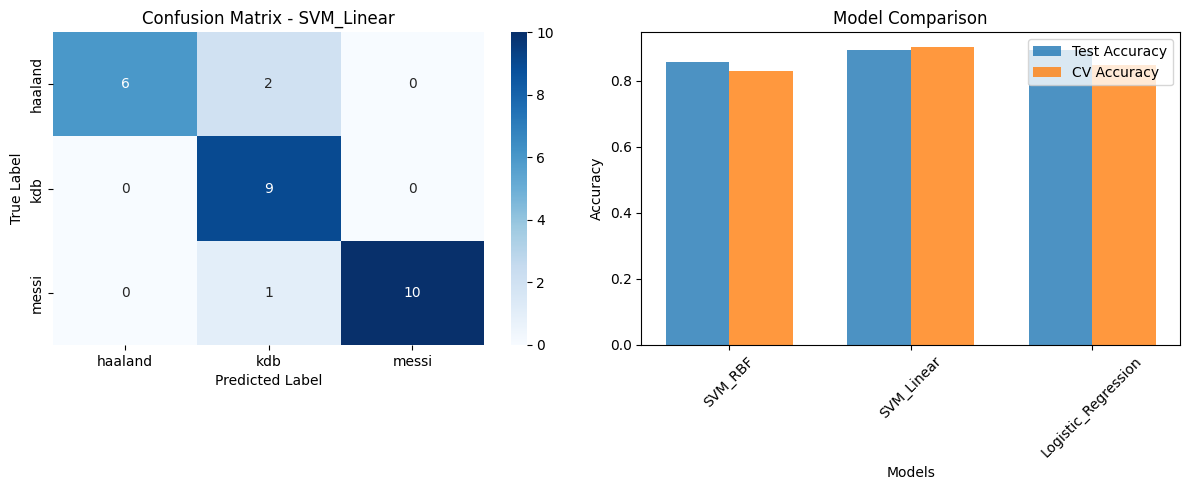

In [102]:
reverse_class_dict = {v: k for k, v in class_dict.items()}
class_names = [reverse_class_dict[i] for i in sorted(reverse_class_dict.keys())]

best_model = detailed_evaluation(results, best_models, X_test, y_test, best_model_name, class_names)

In [103]:
import joblib

joblib.dump(best_model, f'best_saved_model.pkl')
print(f"best_saved_model.pkl")

best_saved_model.pkl


In [104]:
import json 
with open("class_dictionary.json", "w") as f:
    f.write(json.dumps(class_dict))

In [105]:
reverse_class_dict

{1: 'haaland', 2: 'kdb', 3: 'messi'}

In [106]:
class_names

['haaland', 'kdb', 'messi']

In [107]:
with open("class_dictionary_reverse.json", "w") as f:
    f.write(json.dumps(reverse_class_dict))